# Project 4: Final Project - Random Acts of Pizza
### Predicting altruism through free pizza

This project is originated from the Kaggle competition https://www.kaggle.com/c/random-acts-of-pizza. We will create an algorithm to predict which requests will recieve pizza and which on will not.  The competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. This data was collected and graciously shared by Althoff et al (http://www.timalthoff.com/). 

**Reference Paper:**
Tim Althoff, Cristian Danescu-Niculescu-Mizil, Dan Jurafsky. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Proceedings of ICWSM, 2014. (http://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf)


## Approach 


**Step 1:  Exploratory Data Analysis **

**Step 2:  Create a Baseline Model **

**Step 3:  Feature Engineering **

- Preprocessing data 
    - data cleansing 
    - data transformation

- Use other meta-data from the data set, such as,
    - request_text_edit_aware
    - request_title
    - requester_account_age_in_days_at_request
    - requester_days_since_first_post_on_raop_at_request
    - requester_number_of_comments_at_request
    - requester_number_of_comments_in_raop_at_request
    - requester_number_of_posts_at_request
    - requester_number_of_posts_on_raop_at_request
    - requester_number_of_subreddits_at_request
    - requester_subreddits_at_request
    - requester_upvotes_minus_downvotes_at_request
    - requester_upvotes_plus_downvotes_at_request
    - requester_username
    - unix_timestamp_of_request
    - unix_timestamp_of_request_utc
    - other features includes:
        - number of requests made by the same user
        - number of requests fulfilled or % of requests fulfilled, etc
    
- Generate new features from the data set such as, 
    - Politeness, 
    - Evidentiality, 
    - Reciprocity, 
    - Sentiment, 
    - Length, etc

**Step 4:  Algorithm / Model Selection **

- Generative Models 
    - Naive Bayes 
- Discriminative Models
    - Logistic Regression 
    - SVM 
- Neural Network 


**Step 5:  Error Analysis & Optimization ** 


**Step 6:  Final Model ** 




## Load Data

In [1]:
import re
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.svm import LinearSVC as LSVC
from sklearn.decomposition import TruncatedSVD as TSVD
from scipy.sparse import hstack
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for model selection 
from sklearn.model_selection import train_test_split

# json libraries to parse json file
import json
from pandas.io.json import json_normalize

import gensim
from gensim import utils

/Users/lauc136/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lauc136/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read json file
train_json = json.load(open('train.json'))

# normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# read json file
test_json = json.load(open('test.json'))

# normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

In [3]:
columns = test_json_df.columns.values
columns = np.append(columns, ['requester_received_pizza'])

train_json_with_test_df = train_json_df[columns]


# 1.0 EDA 

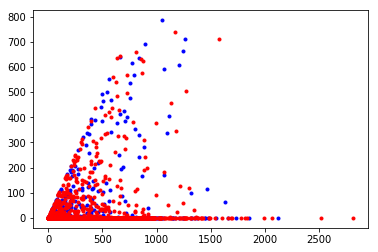

In [4]:

plt.plot(train_json_df[train_json_df.requester_received_pizza].requester_account_age_in_days_at_request, 
        train_json_df[train_json_df.requester_received_pizza].requester_days_since_first_post_on_raop_at_request, "b.")
plt.plot(train_json_df[~train_json_df.requester_received_pizza].requester_account_age_in_days_at_request, 
        train_json_df[~train_json_df.requester_received_pizza].requester_days_since_first_post_on_raop_at_request, "r.")
plt.show()

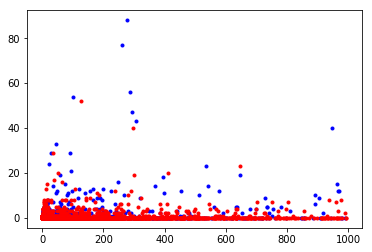

In [5]:
plt.plot(train_json_df[train_json_df.requester_received_pizza].requester_number_of_comments_at_request, 
        train_json_df[train_json_df.requester_received_pizza].requester_number_of_comments_in_raop_at_request, "b.")
plt.plot(train_json_df[~train_json_df.requester_received_pizza].requester_number_of_comments_at_request, 
        train_json_df[~train_json_df.requester_received_pizza].requester_number_of_comments_in_raop_at_request, "r.")
plt.show()



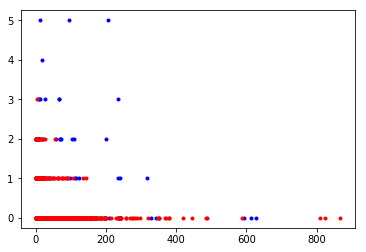

In [6]:
plt.plot(train_json_df[train_json_df.requester_received_pizza].requester_number_of_posts_at_request, 
        train_json_df[train_json_df.requester_received_pizza].requester_number_of_posts_on_raop_at_request, "b.")
plt.plot(train_json_df[~train_json_df.requester_received_pizza].requester_number_of_posts_at_request, 
        train_json_df[~train_json_df.requester_received_pizza].requester_number_of_posts_on_raop_at_request, "r.")
plt.show()


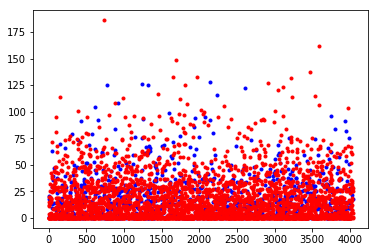

In [7]:
plt.plot(train_json_df[train_json_df.requester_received_pizza].requester_number_of_subreddits_at_request, "b.")
plt.plot(train_json_df[~train_json_df.requester_received_pizza].requester_number_of_subreddits_at_request, "r.")
plt.show()

In [8]:
train_json_df.requester_subreddits_at_request

0                                                      []
1       [AskReddit, Eve, IAmA, MontereyBay, RandomKind...
2                                                      []
3            [AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]
4       [GayBrosWeightLoss, RandomActsOfCookies, Rando...
5       [AdviceAnimals, AskReddit, Autos, IAmA, Random...
6                                                      []
7       [AskReddit, IAmA, Music, Random_Acts_Of_Pizza,...
8       [AlisonBrie, AskReddit, Games, IAmA, Naruto, N...
9                                             [AskReddit]
10      [4chan, AskReddit, IAmA, ImGoingToHellForThis,...
11                                                     []
12                                                     []
13      [AskReddit, Atlanta, GaState, Jokes, MMA, OkCu...
14      [Random_Acts_Of_Pizza, pics, reddit.com, tipof...
15      [AdviceAnimals, AskReddit, IAmA, WTF, WritersG...
16          [AskReddit, Random_Acts_Of_Pizza, aww, trees]
17      [Rando

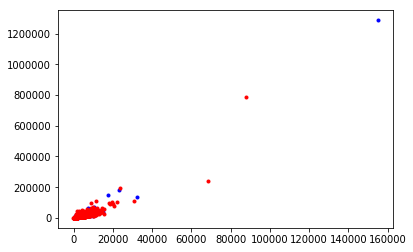

In [9]:
plt.plot(train_json_df[train_json_df.requester_received_pizza].requester_upvotes_minus_downvotes_at_request, 
        train_json_df[train_json_df.requester_received_pizza].requester_upvotes_plus_downvotes_at_request, "b.")
plt.plot(train_json_df[~train_json_df.requester_received_pizza].requester_upvotes_minus_downvotes_at_request, 
        train_json_df[~train_json_df.requester_received_pizza].requester_upvotes_plus_downvotes_at_request, "r.")
plt.show()

# 2.0 Feature Exploration

## 2.1 Just Bag of Words

In [10]:

train_data = train_json_df.request_text_edit_aware.as_matrix()
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232,)
dev data shape: (808,)


In [11]:
vectorizer = CountVectorizer(stop_words='english', ngram_range = (1, 2))
train_bag_of_words = vectorizer.fit_transform(train_data)
dev_bag_of_words = vectorizer.transform(dev_data)

lr = LogisticRegression(tol=0.01)
parameters = {'C':np.linspace(0.0001, 0.001, 10)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_bag_of_words, train_labels) 
pred_dev_prob = clf.predict_proba(dev_bag_of_words)[:,0]

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.0001}


0.59738661712988328

## 2.2 Bag of words + additional features

In [12]:
from sklearn.decomposition import PCA

# training labels
train_labels = train_json_with_test_df.requester_received_pizza.astype(int)

# text factors
vectorizer = CountVectorizer(stop_words='english', ngram_range = (1, 2))
train_bag_of_words = vectorizer.fit_transform(train_json_with_test_df.request_text_edit_aware.as_matrix(), train_labels)

# other factors
train_other_data = train_json_with_test_df[['requester_account_age_in_days_at_request', \
                                    'requester_days_since_first_post_on_raop_at_request', \
                                    'requester_number_of_comments_at_request', \
                                    'requester_number_of_comments_in_raop_at_request', \
                                    'requester_number_of_posts_at_request', \
                                    'requester_number_of_posts_on_raop_at_request', \
                                    'requester_number_of_subreddits_at_request', \
                                    'requester_upvotes_minus_downvotes_at_request', \
                                    'requester_upvotes_plus_downvotes_at_request']].as_matrix()

print(train_bag_of_words.shape)
print(train_other_data.shape)
train_data = np.hstack((train_bag_of_words.todense(), train_other_data))


# split the training data into training data and dev data 
train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    

(4040, 101153)
(4040, 9)


In [13]:
lr = LogisticRegression()
parameters = {'C':[0.001, 0.01, 0.1, 1]}
clf = GridSearchCV(lr, parameters)
clf.fit(train_data, train_labels)
pred_dev_prob = clf.predict_proba(dev_data)[:,1]

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.01}


0.58156501305897579

## 2.3 NMF of TFIDF 

In [14]:

train_data = train_json_df.request_text_edit_aware.as_matrix()
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232,)
dev data shape: (808,)


In [15]:
TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pandas as pd;

vectorizer = CountVectorizer(analyzer='word', stop_words='english');
x_counts = vectorizer.fit_transform(train_data);

In [16]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [17]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [18]:
num_topics=10
model = NMF(n_components=num_topics, init='nndsvd');

#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=10, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [19]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);
get_nmf_topics(model, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,pay,pizza,thank,appreciated,love,hungry,buy,appreciate,help,edit
1,money,just,consideration,greatly,forever,student,cheese,thanks,thanks,nevermind
2,forward,like,reddit,reciprocated,pie,help,people,greatly,eat,california
3,food,good,hope,payed,family,just,works,really,redditors,location
4,just,want,guys,later,really,college,week,brother,yall,adding
5,really,haven,pizzareceived,super,wired,broke,soul,college,advance,pie
6,friday,celebrate,raop,max,tonight,pretty,great,reading,broke,spelling
7,paid,hut,weeks,monies,sister,blasting,hopefully,home,house,error
8,don,craving,advance,weeks,gift,say,pizza,student,dinner,imagine
9,ll,really,suffolk,help,lt,nice,advance,right,today,illustrator


In [20]:
train_data_with_topics = model.transform(xtfidf_norm)

In [21]:
for i in range(0, 10, 1):
    print("success rate for topic #{} = {}".format(i+1, \
                                    np.sum(train_labels[train_data_with_topics[:, i] > 0])/train_labels.size))

success rate for topic #1 = 0.2332920792079208
success rate for topic #2 = 0.19709158415841585
success rate for topic #3 = 0.13366336633663367
success rate for topic #4 = 0.1188118811881188
success rate for topic #5 = 0.12530940594059406
success rate for topic #6 = 0.10798267326732673
success rate for topic #7 = 0.11138613861386139
success rate for topic #8 = 0.12004950495049505
success rate for topic #9 = 0.16120049504950495
success rate for topic #10 = 0.14820544554455445


# 3. Stanford Paper - Copy From GC (with minor changes)

In [470]:
# read json file
train_json = json.load(open('train.json'))

# normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# read json file
test_json = json.load(open('test.json'))

# normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

print("Train shape: ", train_json_df.shape)
print("Test shape: ", test_json_df.shape)

train_only_columns = set(train_json_df.columns.values)-set(test_json_df.columns.values)
print("Columns in Train but not Test:\n",train_only_columns)
test_only_columns = set(test_json_df.columns.values)-set(train_json_df.columns.values)
print("\nColumns in Test but not Train:",test_only_columns)
test_w_train_col = train_json_df[test_json_df.columns.values]

Train shape:  (4040, 32)
Test shape:  (1631, 17)
Columns in Train but not Test:
 {'requester_received_pizza', 'number_of_upvotes_of_request_at_retrieval', 'requester_user_flair', 'requester_number_of_posts_at_retrieval', 'requester_upvotes_plus_downvotes_at_retrieval', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_on_raop_at_retrieval', 'number_of_downvotes_of_request_at_retrieval', 'requester_number_of_comments_at_retrieval', 'post_was_edited', 'request_text', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_upvotes_minus_downvotes_at_retrieval', 'request_number_of_comments_at_retrieval', 'requester_account_age_in_days_at_retrieval'}

Columns in Test but not Train: set()


In [471]:
# 0 means the user doesn't receive pizza & 1 means the user receives pizza
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

# split the training data into training data and dev data 
train_data, dev_data, train_labels, dev_labels = \
            train_test_split(test_w_train_col, train_labels, test_size=0.2, random_state=12)

In [472]:
train_text=train_data['request_text_edit_aware'] +' '+train_data['request_title']
dev_text=dev_data['request_text_edit_aware'] +' '+dev_data['request_title']

In [473]:
# Narratives per Standford paper
money = ["money", "now", "broke", "week", "until", "time",
          "last", "day", "when", "today", "tonight", "paid", "next",
          "first", "night", "after", "tomorrow", "month", "while",
          "account", "before", "long", "Friday", "rent", "buy",
          "bank", "still", "bills", "ago", "cash", "due",
          "soon", "past", "never", "paycheck", "check", "spent",
          "years", "poor", "till", "yesterday", "morning", "dollars",
          "financial", "hour", "bill", "evening", "credit",
          "budget", "loan", "bucks", "deposit", "dollar", "current",
          "payed"]
job =["work", "job", "paycheck", "unemployment", "interview",
          "fired", "employment", "hired", "hire"]
student = ["college", "student", "school", "roommate",
          "studying", "university", "finals", "semester",
          "class", "study", "project", "dorm", "tuition"]
family =["family", "mom", "wife", "parents", "mother", "husband",
           "dad", "son", "daughter", "father", "parent",
           "mum"]
craving = ["friend", "girlfriend", "craving", "birthday",
          "boyfriend", "celebrate", "party", "game", "games",
          "movie", "date", "drunk", "beer", "celebrating", "invited",
          "drinks", "crave", "wasted", "invite"]

narratives = [money, job, student, family, craving]


In [474]:
import string
from nltk.stem.porter import PorterStemmer
def pre_proccess(s):
    s = re.sub("[^\w']|_", " ", s) 
    s=s.translate(str.maketrans(' ',' ',string.punctuation))#strip punctuation before looking
    s=s.lower()
   # p_stemmer = PorterStemmer()
    #s = ' '.join([p_stemmer.stem(i) for i in s.split()])    
    return s

In [475]:
def construct_ft_mat(train_data):
    feat_mat=pd.DataFrame()
    
    feat_mat['hour_request']=pd.to_datetime(train_data['unix_timestamp_of_request_utc'],unit = 's').dt.hour
    feat_mat['day_request']=pd.to_datetime(train_data['unix_timestamp_of_request_utc'],unit = 's').dt.day 
    feat_mat['month_request']=pd.to_datetime(train_data['unix_timestamp_of_request_utc'],unit = 's').dt.month
    feat_mat['community_age'] = (pd.to_datetime(train_data['unix_timestamp_of_request_utc'],utc = True, unit = 's') - \
                                pd.to_datetime('2010-12-8', format='%Y-%m-%d')).astype('timedelta64[D]')

    feat_mat['first_post']=np.log(train_data['requester_days_since_first_post_on_raop_at_request']+1)
    feat_mat['upvotes_minus_downvotes']=train_data['requester_upvotes_minus_downvotes_at_request']
    feat_mat['upvotes_plus_downvotes_at_request']=np.log(train_data['requester_upvotes_plus_downvotes_at_request']+1)
    upvotes=train_data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request'] + row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    downvotes=train_data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request']- row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    feat_mat['upvotes']=upvotes
    feat_mat['vote_ratio']=upvotes/(upvotes+downvotes+1)
    feat_mat['req_age']=np.log(train_data['requester_account_age_in_days_at_request']+1)
    feat_mat['num_subs']=np.log(train_data['requester_number_of_subreddits_at_request']+1)
    feat_mat['num_posts']=np.log(train_data['requester_number_of_posts_at_request']+1)
    feat_mat['pizza_activity']=np.log(train_data['requester_number_of_posts_on_raop_at_request']+1)
    feat_mat['len_request']=np.log(train_data['request_text_edit_aware'].apply(len)+1)
    feat_mat['len_title']=np.log(train_data['request_title'].apply(len)+1)
    #feat_mat['len_name']=train_data['requester_username'].apply(len)
    feat_mat['pizza_comments']=np.log(train_data['requester_number_of_comments_in_raop_at_request']+1)
    feat_mat['hyperlink'] = train_data['request_text_edit_aware'].apply(lambda x: 1 if re.search("http|www", x) else 0)
    # reciprocity indicator
    feat_mat['reciprocity'] = train_data['request_text_edit_aware'].apply(lambda x:1 if re.search("repay|pay.+back|pay.+forward|return.+favor|reciprocate", x) 
                                               else 0)
    feat_mat['politeness'] = train_data['request_text_edit_aware'].apply(lambda x: 1 if re.search("thank|appreciate|advance|appreciated|consideration", x) else 0)
    
    return feat_mat

def find_narr(narr,s):
    ct=0
    for word in narr:
        ct+=s.split().count(word)
    return ct/len(s.split())
    #return int(ct > 0)



In [476]:
feat_mat=construct_ft_mat(train_data)
dev_mat=construct_ft_mat(dev_data)

In [485]:
train_text_clean=train_text.apply(lambda s:pre_proccess(s))
dev_text_clean=dev_text.apply(lambda s: pre_proccess(s))     
for n in narratives:
    feat_mat[n[0]]=train_text_clean.apply(lambda s: find_narr(n,s))
    dev_mat[n[0]]=dev_text_clean.apply(lambda s: find_narr(n,s))
    

t_mat=feat_mat.as_matrix()
d_mat=dev_mat.as_matrix()

In [486]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), preprocessor=pre_proccess,stop_words='english',norm='l2',sublinear_tf=True) 
train_bag_of_words = vectorizer.fit_transform(train_text)
dev_bag_of_words = vectorizer.transform(dev_text)

In [487]:
lsvc = LSVC(C=1, penalty="l1", dual=False,random_state=42).fit(train_bag_of_words,train_labels)
model = SelectFromModel(lsvc, prefit=True)
#S=StandardScaler(with_mean=False)
#X_new = model.transform(S.fit_transform(train_bag_of_words))
X_new = model.transform(train_bag_of_words)
print(X_new.shape)

#d_new=model.transform(S.transform(dev_bag_of_words))
d_new=model.transform(dev_bag_of_words)

f_new=hstack([X_new,t_mat])
dev_new=hstack([d_new,d_mat])

(3232, 944)


In [488]:
lr = LogisticRegression()
parameters = {'C':np.linspace(2, 3, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(f_new, train_labels)
pred_dev_prob = clf.predict_proba(dev_new)[:,1]
pred_dev_label = clf.predict(dev_new)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 2.5454545454545454}


0.69213815789473687

In [489]:
dev_labels[dev_labels != pred_dev_label]

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [490]:
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,2), preprocessor=pre_proccess,stop_words='english',norm='l2',sublinear_tf=True) 
train_bag_of_words = vectorizer.fit_transform(train_text)
dev_bag_of_words = vectorizer.transform(dev_text)

In [491]:
lsvc = LSVC(C=1, penalty="l1", dual=False,random_state=42).fit(train_bag_of_words,train_labels)
model = SelectFromModel(lsvc, prefit=True)
#S=StandardScaler(with_mean=False)
#X_new = model.transform(S.fit_transform(train_bag_of_words))
X_new = model.transform(train_bag_of_words)
print(X_new.shape)

#d_new=model.transform(S.transform(dev_bag_of_words))
d_new=model.transform(dev_bag_of_words)

f_new=hstack([X_new,t_mat])
dev_new=hstack([d_new,d_mat])

(3232, 1037)


In [492]:
import xgboost as xgb
#create dmatrices
dtrain = xgb.DMatrix(f_new, train_labels)
dtest = xgb.DMatrix(dev_new, dev_labels)

#booster parameter
param = {'max_depth': 7, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'
         , 'scale_pos_weight': 3.06,'max_delta_step':1,'subsample':.8}#9 depth if sublin false
param['nthread'] = 4
param['eval_metric'] = 'auc'

#specify validation set to watch performance
evallist = [(dtest, 'eval'), (dtrain, 'train')]

#train model
num_round = 100
bst = xgb.train(param.items(), dtrain, num_round, evallist)

[0]	eval-auc:0.596271	train-auc:0.756954
[1]	eval-auc:0.625337	train-auc:0.815551
[2]	eval-auc:0.634548	train-auc:0.845353
[3]	eval-auc:0.634079	train-auc:0.871819
[4]	eval-auc:0.643035	train-auc:0.895077
[5]	eval-auc:0.636435	train-auc:0.906916
[6]	eval-auc:0.636608	train-auc:0.916473
[7]	eval-auc:0.638602	train-auc:0.934033
[8]	eval-auc:0.639864	train-auc:0.944047
[9]	eval-auc:0.645037	train-auc:0.953804
[10]	eval-auc:0.642216	train-auc:0.961064
[11]	eval-auc:0.652533	train-auc:0.966652
[12]	eval-auc:0.655099	train-auc:0.971863
[13]	eval-auc:0.657977	train-auc:0.974616
[14]	eval-auc:0.655559	train-auc:0.978691
[15]	eval-auc:0.649951	train-auc:0.980079
[16]	eval-auc:0.643676	train-auc:0.983286
[17]	eval-auc:0.6469	train-auc:0.986077
[18]	eval-auc:0.648602	train-auc:0.988374
[19]	eval-auc:0.654646	train-auc:0.991933
[20]	eval-auc:0.65713	train-auc:0.992882
[21]	eval-auc:0.654326	train-auc:0.994082
[22]	eval-auc:0.652344	train-auc:0.994679
[23]	eval-auc:0.6481	train-auc:0.996173
[24]	ev

## 4. Follow the Stanford Paper exactly


In [533]:
# read json file
train_json = json.load(open('train.json'))

# normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# read json file
test_json = json.load(open('test.json'))

# normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

print("Train shape: ", train_json_df.shape)
print("Test shape: ", test_json_df.shape)


Train shape:  (4040, 32)
Test shape:  (1631, 17)


In [534]:
# 0 means the user doesn't receive pizza & 1 means the user receives pizza
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

# split the training data into training data and dev data 
train_data, dev_data, train_labels, dev_labels = \
            train_test_split(test_w_train_col, train_labels, test_size=0.2, random_state=12)

In [535]:
train_text=train_data['request_text_edit_aware'] + ' ' + train_data['request_title']
dev_text=dev_data['request_text_edit_aware'] + ' ' + dev_data['request_title']

In [536]:
# Narratives per Standford paper
money = ["money", "now", "broke", "week", "until", "time",
          "last", "day", "when", "today", "tonight", "paid", "next",
          "first", "night", "after", "tomorrow", "month", "while",
          "account", "before", "long", "Friday", "rent", "buy",
          "bank", "still", "bills", "ago", "cash", "due",
          "soon", "past", "never", "paycheck", "check", "spent",
          "years", "poor", "till", "yesterday", "morning", "dollars",
          "financial", "hour", "bill", "evening", "credit",
          "budget", "loan", "bucks", "deposit", "dollar", "current",
          "payed"]
job =["work", "job", "paycheck", "unemployment", "interview",
          "fired", "employment", "hired", "hire"]
student = ["college", "student", "school", "roommate",
          "studying", "university", "finals", "semester",
          "class", "study", "project", "dorm", "tuition"]
family =["family", "mom", "wife", "parents", "mother", "husband",
           "dad", "son", "daughter", "father", "parent",
           "mum"]
craving = ["friend", "girlfriend", "craving", "birthday",
          "boyfriend", "celebrate", "party", "game", "games",
          "movie", "date", "drunk", "beer", "celebrating", "invited",
          "drinks", "crave", "wasted", "invite"]

narratives = [money, job, student, family, craving]

In [537]:
import string
from nltk.stem.porter import PorterStemmer
def pre_proccess(s):
    s = re.sub("[^\w']|_", " ", s) 
    s=s.translate(str.maketrans(' ',' ',string.punctuation))#strip punctuation before looking
    s=s.lower()
    #p_stemmer = PorterStemmer()
    #s = ' '.join([p_stemmer.stem(i) for i in s.split()])    
    return s

In [556]:
def construct_ft_mat(train_data):
    feat_mat=pd.DataFrame()
    
    feat_mat['community_age'] = (pd.to_datetime(train_data['unix_timestamp_of_request_utc'],utc = True, unit = 's') - \
                                pd.to_datetime('2010-12-8', format='%Y-%m-%d')).astype('timedelta64[D]')
    
    feat_mat['community_age'] = (feat_mat['community_age'] * 10./feat_mat.community_age.max()).astype(int)

    feat_mat['first_half_of_month']=(pd.to_datetime(train_data['unix_timestamp_of_request_utc'],unit = 's').dt.day <= 15).astype(int) 

    feat_mat['gratitude'] = train_data['request_text_edit_aware'].apply( \
                                    lambda x: 1 if re.search("thank|appreciate|advance|consider", x) else 0)
    feat_mat['include_image'] = train_data['request_text_edit_aware'].apply(lambda x: 1 if re.search("http|www", x) else 0)

    feat_mat['reciprocity'] = train_data['request_text_edit_aware'].apply(\
                                    lambda x:1 if re.search("repay|pay.+back|pay.+forward|return.+favor|reciprocate", x) else 0)
    feat_mat['len_request']= (train_data['request_text_edit_aware'].apply(len) > 100).astype(int)

    feat_mat['karma']=(train_data['requester_upvotes_minus_downvotes_at_request']* 10.\
                                         /train_data.requester_upvotes_minus_downvotes_at_request.max()).astype(int)

    feat_mat['posted_in_raop_before']= (train_data['requester_number_of_posts_on_raop_at_request'] > 0).astype(int)
    
    feat_mat['posted_before']= (train_data['requester_number_of_posts_at_request'] > 0).astype(int)
    
    return feat_mat

def find_narr(narr,s):
    ct=0
    for word in narr:
        ct+=s.split().count(word)
    #return ct/len(s.split())
    return int(ct > 0)


In [557]:
feat_mat=construct_ft_mat(train_data)
dev_mat=construct_ft_mat(dev_data)

In [558]:
train_text_clean=train_text.apply(lambda s:pre_proccess(s))
dev_text_clean=dev_text.apply(lambda s: pre_proccess(s))     
for n in narratives:
    feat_mat[n[0]]=train_text_clean.apply(lambda s: find_narr(n,s))
    dev_mat[n[0]]=dev_text_clean.apply(lambda s: find_narr(n,s))

In [559]:
vectorizer = TfidfVectorizer(min_df = 2, ngram_range=(1,1), preprocessor=pre_proccess,stop_words='english',norm='l1',sublinear_tf=True)
train_bag_of_words = vectorizer.fit_transform(train_text)
dev_bag_of_words = vectorizer.transform(dev_text)

In [560]:
t_mat = feat_mat.as_matrix()
d_mat = dev_mat.as_matrix()
f_new=hstack([train_bag_of_words,t_mat])
dev_new=hstack([dev_bag_of_words,d_mat])

In [563]:
lr = LogisticRegression()
#parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}
parameters = {'C':np.linspace(10, 100, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(f_new, train_labels)
pred_dev_prob = clf.predict_proba(dev_new)[:,1]
pred_dev_labels = clf.predict(dev_new)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 18.18181818181818}


0.63738486842105258

In [564]:
dev_labels[dev_labels != pred_dev_labels]

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Try to augment the data to have more positive repsonse observations

In [545]:
# mean for each non-text feature that gets pizza 
mean_features = feat_mat[train_labels == 1].mean()
std_features = feat_mat[train_labels == 1].std()

mean_text_len = train_data[train_labels == 1]['request_text_edit_aware'].apply(lambda x: len(x.split())).mean()
std_text_len = train_data[train_labels == 1]['request_text_edit_aware'].apply(lambda x: len(x.split())).std()

In [546]:
augment_sample_size = 1000

# probability for bag of words
nb = MultinomialNB()
nb.fit(train_bag_of_words, train_labels)

prob = np.zeros(nb.feature_log_prob_.shape)

for i in range(nb.feature_log_prob_.shape[0]): 
    for j in range(nb.feature_log_prob_.shape[1]):
        prob[i,j] = np.exp(nb.feature_log_prob_[i][j])


# generate new samples
new_train_other = pd.DataFrame(columns = ['community_age', 'first_half_of_month', 'gratitude', 'include_image', \
                                         'reciprocity', 'len_request', 'karma', 'posted_in_raop_before', \
                                         'posted_before', 'money', 'work', 'college', 'family', 'friend'])
new_train_text = pd.DataFrame(columns = ['request_text_edit_aware'])


for i in range(augment_sample_size):
    # generate other features
    community_age = int(std_features.community_age * np.random.rand() + mean_features.community_age)
    first_half_of_month = np.random.choice(2, 1, p = [1-mean_features.first_half_of_month, mean_features.first_half_of_month])[0]
    gratitude = np.random.choice(2, 1, p = [1-mean_features.gratitude, mean_features.gratitude])[0]
    include_image = np.random.choice(2, 1, p = [1-mean_features.include_image, mean_features.include_image])[0]
    reciprocity = np.random.choice(2, 1, p = [1-mean_features.reciprocity, mean_features.reciprocity])[0]
    length = int(std_text_len * np.random.rand() + mean_text_len)
    len_request = int(length > 100)
    karma = int(std_features.karma * np.random.rand() + mean_features.karma)
    posted_in_raop_before = np.random.choice(2, 1, p = [1-mean_features.posted_in_raop_before, mean_features.posted_in_raop_before])[0]
    posted_before = np.random.choice(2, 1, p = [1-mean_features.posted_before, mean_features.posted_before])[0]
    money = np.random.choice(2, 1, p = [1-mean_features.money, mean_features.money])[0]
    work = np.random.choice(2, 1, p = [1-mean_features.work, mean_features.work])[0]
    college = np.random.choice(2, 1, p = [1-mean_features.college, mean_features.college])[0]
    family = np.random.choice(2, 1, p = [1-mean_features.family, mean_features.family])[0]
    friend = np.random.choice(2, 1, p = [1-mean_features.friend, mean_features.friend])[0]
    
    new_train_other.loc[i] = [community_age, first_half_of_month, gratitude, include_image, \
                                reciprocity, len_request, karma, posted_in_raop_before, \
                                posted_before, money, work, college, family, friend]
    
    # generate text
    new_text = []
    for j in np.random.choice(len(vectorizer.vocabulary_), size=length, p=prob[1,:]):
        new_text.append(list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(j)])
    
    new_train_text.loc[i] = " ".join(new_text)
    
new_train_other = new_train_other.astype(int)

In [549]:
new_train_labels = np.append(train_labels, [1] * augment_sample_size)

t_mat = feat_mat.append(new_train_other).as_matrix()
d_mat = dev_mat.as_matrix()

vectorizer = TfidfVectorizer(min_df = 2, ngram_range=(1,1), preprocessor=pre_proccess,stop_words='english',norm='l1',sublinear_tf=True)
train_bag_of_words = vectorizer.fit_transform(train_text.append(new_train_text.request_text_edit_aware))
dev_bag_of_words = vectorizer.transform(dev_text)

lsvc = LSVC(C=1, penalty="l1", dual=False,random_state=42).fit(train_bag_of_words,new_train_labels)
model = SelectFromModel(lsvc, prefit=True)
#S=StandardScaler(with_mean=False)
#X_new = model.transform(S.fit_transform(train_bag_of_words))
X_new = model.transform(train_bag_of_words)
print(X_new.shape)

#d_new=model.transform(S.transform(dev_bag_of_words))
d_new=model.transform(dev_bag_of_words)

f_new=hstack([X_new,t_mat])
dev_new=hstack([d_new,d_mat])


(4232, 155)


In [554]:
lr = LogisticRegression()
#parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}
parameters = {'C':np.linspace(100, 1000, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(f_new, new_train_labels)
pred_dev_prob = clf.predict_proba(dev_new)[:,1]
pred_dev_labels = clf.predict(dev_new)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 245.45454545454547}


0.61134046052631574

In [ ]:
dev_labels[dev_labels != pred_dev_labels]

## Questions

1) ML doesn't need to be parsimony but will it hurt because of overfitting?